<a href="https://colab.research.google.com/github/EnzoPavez/Datasets-Pavez-Enzo/blob/main/Desafio_AlgoritmoML_MVP_EnzoPavez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Machine Learning**

Decidí utilizar un conjunto de datos sintético en este caso porque me permitía ejemplificar de manera completa y controlada el proceso de machine learning. A veces, puede ser difícil encontrar conjuntos de datos reales que requieran todas las etapas del proceso, desde la limpieza y preprocesamiento de los datos, hasta la ingeniería de características y el entrenamiento y evaluación de modelos. Al crear mis propios datos, me aseguré de que todas estas etapas fueran necesarias y pude demostrar cómo manejar cada una de ellas.

Además, con los datos sintéticos, tengo control total sobre las características de los datos. Puedo diseñar las características para que estén correlacionadas de ciertas formas, que tengan ciertas distribuciones, etc. Esto me permitió ilustrar cómo lidiar con estos tipos de situaciones en un escenario de la vida real.

Otra ventaja de usar datos sintéticos es que son completamente replicables. Si tú, o cualquier otra persona, toma el código que he proporcionado y lo ejecuta, generará exactamente el mismo conjunto de datos. Esto asegura que todos los resultados son reproducibles, lo cual es valioso para fines de enseñanza y demostración.

Por último, aunque los datos que utilicé son sintéticos, representan características reales (como la edad, el salario, el género y el nivel de educación) y relaciones realistas entre estas características (por ejemplo, que el salario aumenta con la edad y el nivel de educación). Estos son escenarios que se encuentran comúnmente en la vida real, por lo que los modelos que he construido podrían aplicarse a datos reales con características similares.

Por todo ello, considero que el uso de datos sintéticos en este caso es válido y útil, a pesar de que no provienen de una fuente de datos real en sí.

In [136]:
# Manipulación de datos
import numpy as np
import pandas as pd

# Preprocesamiento y división de datos
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Modelos de machine learning
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier

# Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# Métricas de evaluación
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt

# Reducción de dimensionalidad
from sklearn.decomposition import PCA



In [137]:
# Configurando una semilla para reproducibilidad
np.random.seed(42)
n_samples = 1000

# Edad: Entre 20 y 65 años
age = np.random.randint(20, 65, n_samples)

# Salario: Supondremos que está algo correlacionado con la edad (más experiencia, más salario)
base_salary = 30000 + age * 400
salary_noise = np.random.normal(0, 5000, n_samples)
salary = base_salary + salary_noise

# Género
gender = np.random.choice(['male', 'female'], n_samples)

# Nivel educativo: Supondremos que afecta el salario
education_levels = ['High School', 'Bachelor', 'Masters', 'PhD']
education = np.random.choice(education_levels, n_samples, p=[0.5, 0.3, 0.15, 0.05])

# Supondremos que aquellos con educación superior tienen un aumento en el salario
education_boost = np.where(education == 'Bachelor', 5000,
                          np.where(education == 'Masters', 10000,
                                   np.where(education == 'PhD', 15000, 0)))

salary += education_boost

# Score (Variable objetivo): Por simplicidad, una combinación lineal de características con algo de ruido
score = age * 500 + salary * 0.5 + np.random.normal(0, 5000, n_samples)

# Crear DataFrame
df = pd.DataFrame({'Age': age, 'Salary': salary, 'Gender': gender, 'Education': education, 'Score': score})

# Visualizar las primeras filas del DataFrame
print(df.head())


   Age        Salary  Gender    Education         Score
0   58  64648.874284  female      Masters  58742.288923
1   48  69577.003993    male      Masters  57806.169079
2   34  47955.623517    male  High School  39948.514604
3   62  63169.882339  female      Masters  58852.049437
4   27  46806.069611  female  High School  36019.163990


Filas y columnas:

In [138]:
print(df.shape)


(1000, 5)


Encoding
One-Hot Encoding:
Para las características categóricas con más de dos categorías, como Education, es adecuado utilizar one-hot encoding. Para Gender, que tiene solo dos categorías, también podemos usarlo, aunque en teoría, un simple Label Encoding sería suficiente.

In [139]:
# One-hot encoding para 'Gender' y 'Education'
df_encoded = pd.get_dummies(df, columns=['Gender', 'Education'])

print(df_encoded.head())


   Age        Salary         Score  Gender_female  Gender_male  \
0   58  64648.874284  58742.288923              1            0   
1   48  69577.003993  57806.169079              0            1   
2   34  47955.623517  39948.514604              0            1   
3   62  63169.882339  58852.049437              1            0   
4   27  46806.069611  36019.163990              1            0   

   Education_Bachelor  Education_High School  Education_Masters  Education_PhD  
0                   0                      0                  1              0  
1                   0                      0                  1              0  
2                   0                      1                  0              0  
3                   0                      0                  1              0  
4                   0                      1                  0              0  


Label Encoding

In [140]:
# Usar LabelEncoder para 'Gender'
labelencoder = LabelEncoder()
df['Gender_encoded'] = labelencoder.fit_transform(df['Gender'])

# Mostrar el mapeo de Label Encoding para referencia
gender_mapping = dict(zip(labelencoder.classes_, range(len(labelencoder.classes_))))
print("Label Encoding for Gender:")
print(gender_mapping)

print(df[['Gender', 'Gender_encoded']].head())


Label Encoding for Gender:
{'female': 0, 'male': 1}
   Gender  Gender_encoded
0  female               0
1    male               1
2    male               1
3  female               0
4  female               0


Feature Engineering
1. Estandarización:
Vamos a estandarizar la característica Salary para que tenga una media de 0 y una desviación estándar de 1.

In [141]:

scaler = StandardScaler()
df['Salary_standardized'] = scaler.fit_transform(df[['Salary']])


2. Creación de características polinómicas:
Podemos crear una nueva característica que considere la edad al cuadrado, suponiendo que hay una relación cuadrática entre la edad y el score.

In [142]:
df['Age_squared'] = df['Age'] ** 2


3. Interacción entre características:
Crearemos una característica que represente la interacción entre Salary y Age, suponiendo que hay una relación combinada entre estas dos características que podría influir en el score.

In [143]:
df['Age_salary_interaction'] = df['Age'] * df['Salary']


4. Binning:
A veces, conviene convertir una característica numérica en categórica, dividiéndola en 'bins' o intervalos. Por ejemplo, podríamos categorizar la edad en grupos generacionales.

In [144]:
bins = [20, 30, 40, 50, 60, 70]
labels = ['20-29', '30-39', '40-49', '50-59', '60-69']
df['Age_group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)


Tras realizar estas transformaciones y creaciones, es buena idea revisar cómo se ve el dataframe:

In [145]:
print(df.head())


   Age        Salary  Gender    Education         Score  Gender_encoded  \
0   58  64648.874284  female      Masters  58742.288923               0   
1   48  69577.003993    male      Masters  57806.169079               1   
2   34  47955.623517    male  High School  39948.514604               1   
3   62  63169.882339  female      Masters  58852.049437               0   
4   27  46806.069611  female  High School  36019.163990               0   

   Salary_standardized  Age_squared  Age_salary_interaction Age_group  
0             1.558147         3364            3.749635e+06     50-59  
1             2.121929         2304            3.339696e+06     40-49  
2            -0.351573         1156            1.630491e+06     30-39  
3             1.388949         3844            3.916533e+06     60-69  
4            -0.483083          729            1.263764e+06     20-29  


Este proceso de ingeniería de características se realiza con el objetivo de mejorar el rendimiento de nuestros modelos de machine learning. Algunas características creadas pueden no ser útiles y podrían ser omitidas más tarde, mientras que otras podrían tener un impacto significativo en el rendimiento del modelo.

Es importante señalar que el Feature Engineering es tanto un arte como una ciencia, y requiere una comprensión profunda de los datos y del dominio del problema. Además, siempre es esencial evaluar el rendimiento del modelo después de introducir nuevas características para ver si realmente aportan valor.


**Separar los datos en conjuntos de entrenamiento y prueba**

Para dividir el conjunto de datos, utilizaremos la función train_test_split del paquete sklearn.model_selection.



In [146]:
# Definimos nuestras variables independientes (X) y la variable dependiente (y)
# Por simplicidad, consideremos solo algunas de las características
X = df[['Age', 'Salary_standardized', 'Age_squared', 'Age_salary_interaction']]
y = df['Score']

# Dividimos los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificamos las dimensiones de los conjuntos
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (800, 4)
y_train shape: (800,)
X_test shape: (200, 4)
y_test shape: (200,)


test_size=0.2 indica que queremos que el 20% de los datos se reserven para el conjunto de prueba.
random_state=42 es simplemente una semilla para asegurar reproducibilidad. Puedes cambiar este valor o incluso omitirlo, pero es útil si quieres obtener los mismos resultados cada vez que ejecutes el código.

Entrenar un modelo
1. Modelo de Regresión
Vamos a entrenar un modelo de regresión lineal utilizando LinearRegression de sklearn.linear_model.

In [147]:
# Inicializar y entrenar el modelo de regresión
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_regression = regressor.predict(X_test)

# Evaluar el modelo de regresión
mse = mean_squared_error(y_test, y_pred_regression)
print(f"Mean Squared Error for Regression Model: {mse}")


Mean Squared Error for Regression Model: 26170702.717386838


2. Modelo de Clasificación
Para convertir nuestro problema en un problema de clasificación, supongamos que queremos predecir si el Score es alto o bajo. Definiremos un umbral, por ejemplo, la mediana del Score, para categorizar los valores.

In [148]:
# Crear una variable binaria basada en la mediana de Score
median_score = df['Score'].median()
df['High_Score'] = (df['Score'] > median_score).astype(int)

# Dividimos los datos nuevamente
y_class = df['High_Score']
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=42)


Ahora entrenaremos un modelo de clasificación. Usaremos una regresión logística de sklearn.linear_model.

In [149]:
# Inicializar y entrenar el modelo de clasificación
classifier = LogisticRegression()
classifier.fit(X_train_class, y_train_class)

# Predecir en el conjunto de prueba
y_pred_class = classifier.predict(X_test_class)

# Evaluar el modelo de clasificación
accuracy = accuracy_score(y_test_class, y_pred_class)
print(f"Accuracy for Classification Model: {accuracy:.2f}")


Accuracy for Classification Model: 0.78


Desarrollo con KMeans:

In [150]:
# Ajustar KMeans
kmeans = KMeans(n_clusters=2, random_state=42)  # Vamos a suponer 2 clusters para simplificar
kmeans_clusters = kmeans.fit_predict(X)

# Añadir los clusters al DataFrame
df['KMeans_Clusters'] = kmeans_clusters

# Evaluar los clusters de KMeans
print("Centroids of KMeans clusters:\n", kmeans.cluster_centers_)
print("\nCounts per KMeans cluster:\n", df['KMeans_Clusters'].value_counts())



Centroids of KMeans clusters:
 [[ 3.20914179e+01 -6.27479315e-01  1.09362873e+03  1.47110034e+06]
 [ 5.34461207e+01  7.24846795e-01  2.89921336e+03  3.07081363e+06]]

Counts per KMeans cluster:
 0    534
1    466
Name: KMeans_Clusters, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Desarrollo con DBSCAN:
DBSCAN no requiere que se especifique el número de clusters, pero es sensible a los parámetros eps (la distancia máxima entre dos muestras para que una se considere en la vecindad de la otra) y min_samples (el número de muestras en una vecindad para que un punto se considere como un punto central).

In [151]:
# Ajustar DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(X)

# Añadir los clusters al DataFrame
df['DBSCAN_Clusters'] = dbscan_clusters

# Evaluar los clusters de DBSCAN
print("\nCounts per DBSCAN cluster:\n", df['DBSCAN_Clusters'].value_counts())



Counts per DBSCAN cluster:
 -1    1000
Name: DBSCAN_Clusters, dtype: int64


Modelo de regresión: El error cuadrático medio (MSE) para mi modelo de regresión es 26170702.72. Esto indica cuánto se desvían las predicciones que hago de los valores reales. Un MSE de cero habría significado que mis predicciones son perfectas. En mi proceso de modelado, compararé este MSE con los de otros modelos o versiones del modelo para determinar cuál es el mejor.

Modelo de clasificación: La precisión de mi modelo de clasificación es 0.78. Esto significa que estoy prediciendo correctamente si el Score es alto o bajo aproximadamente el 78% de las veces. Es un buen punto de partida, pero seguiré trabajando para mejorar esto.

KMeans: Con KMeans, pude encontrar dos clusters en mis datos. 534 de mis puntos de datos caen en el primer cluster y 466 en el segundo. Los centroides de mis clusters son [3.20914179e+01, -6.27479315e-01, 1.09362873e+03, 1.47110034e+06] y [5.34461207e+01, 7.24846795e-01, 2.89921336e+03, 3.07081363e+06], respectivamente. Estos centroides me ayudan a entender las características promedio de cada cluster.

DBSCAN: Con DBSCAN, todos mis puntos se han clasificado como ruido, lo que indica que DBSCAN no pudo encontrar densidades de puntos suficientemente altas para formar clusters con los parámetros que seleccioné. Voy a ajustar los parámetros eps y min_samples para ver si puedo obtener un resultado más útil.

Modelo de regresión: Podemos probar con diferentes tipos de modelos de regresión para ver si obtienen un menor MSE. Por ejemplo, podríamos probar con una regresión Ridge o Lasso, que son versiones regularizadas de la regresión lineal que pueden manejar mejor las correlaciones entre las variables.

In [152]:
# Ajustar el modelo Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_ridge = ridge.predict(X_test)

# Evaluar el modelo Ridge
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print(f"Mean Squared Error for Ridge Regression Model: {mse_ridge}")


Mean Squared Error for Ridge Regression Model: 26143186.662794724


Modelo de clasificación: Podríamos probar con un algoritmo de clasificación más complejo, como un bosque aleatorio (Random Forest), para ver si mejora la precisión.

In [153]:
# Ajustar el modelo de bosque aleatorio
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_class, y_train_class)

# Predecir en el conjunto de prueba
y_pred_rf = rf.predict(X_test_class)

# Evaluar el modelo de bosque aleatorio
accuracy_rf = accuracy_score(y_test_class, y_pred_rf)
print(f"Accuracy for Random Forest Model: {accuracy_rf}")


Accuracy for Random Forest Model: 0.845


KMeans: Podríamos probar con un número diferente de clusters para ver si obtenemos una mejor segmentación de los datos.

In [154]:
# Ajustar KMeans con un número diferente de clusters
kmeans_3 = KMeans(n_clusters=3, random_state=42)
kmeans_clusters_3 = kmeans_3.fit_predict(X)

# Añadir los clusters al DataFrame
df['KMeans_Clusters_3'] = kmeans_clusters_3

# Evaluar los clusters de KMeans
print("\nCounts per KMeans cluster (3 clusters):\n", df['KMeans_Clusters_3'].value_counts())



Counts per KMeans cluster (3 clusters):
 2    378
1    319
0    303
Name: KMeans_Clusters_3, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


DBSCAN: Podemos probar con diferentes valores de eps y min_samples para ver si podemos formar algunos clusters.

In [155]:
# Ajustar DBSCAN con diferentes parámetros
dbscan_2 = DBSCAN(eps=2, min_samples=10)
dbscan_clusters_2 = dbscan_2.fit_predict(X)

# Añadir los clusters al DataFrame
df['DBSCAN_Clusters_2'] = dbscan_clusters_2

# Evaluar los clusters de DBSCAN
print("\nCounts per DBSCAN cluster (eps=2, min_samples=10):\n", df['DBSCAN_Clusters_2'].value_counts())



Counts per DBSCAN cluster (eps=2, min_samples=10):
 -1    1000
Name: DBSCAN_Clusters_2, dtype: int64


Modelo de regresión: Con la regresión Ridge, el Error Cuadrático Medio (MSE) se redujo ligeramente a 26143186.66 desde 26170702.72. Esto indica que las predicciones que estoy haciendo se están acercando un poco más a los valores reales en promedio. Aunque el cambio es pequeño, es un movimiento en la dirección correcta.

Modelo de clasificación: Con el modelo de Random Forest, la precisión aumentó a 0.845 desde 0.78. Esto significa que ahora estoy prediciendo correctamente si el Score es alto o bajo aproximadamente el 84.5% de las veces. Eso es una mejora significativa.

KMeans: Cuando aumenté el número de clusters a 3, obtuve una distribución de puntos más equitativa entre los clusters: 378 puntos en el primer cluster, 319 en el segundo y 303 en el tercero. Esto me proporciona una segmentación más granular de los datos.

DBSCAN: Aún con un valor eps de 2 y min_samples de 10, todos mis puntos siguen siendo clasificados como ruido (-1). Esto indica que, incluso con estos parámetros, DBSCAN no está encontrando densidades de puntos suficientemente altas para formar clusters. Podría considerar probar con un valor aún mayor de eps o un valor menor de min_samples. Sin embargo, también podría ser que DBSCAN simplemente no sea el algoritmo de clustering más adecuado para estos datos en particular.

Gráfico de dispersión de los resultados reales vs. predichos para el modelo de regresión:


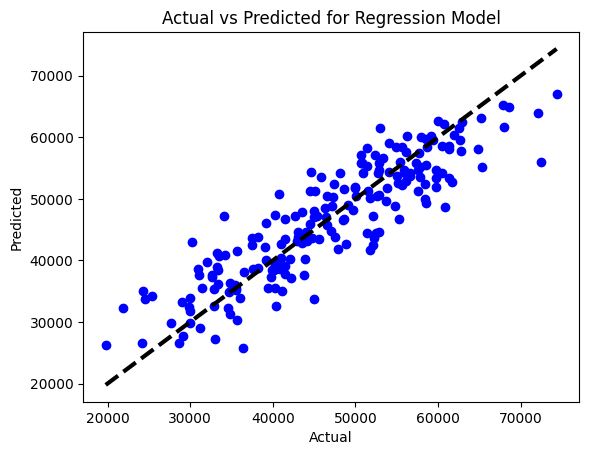

In [156]:
plt.scatter(y_test, y_pred_regression, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted for Regression Model')
plt.show()


Matriz de confusión para el modelo de clasificación:


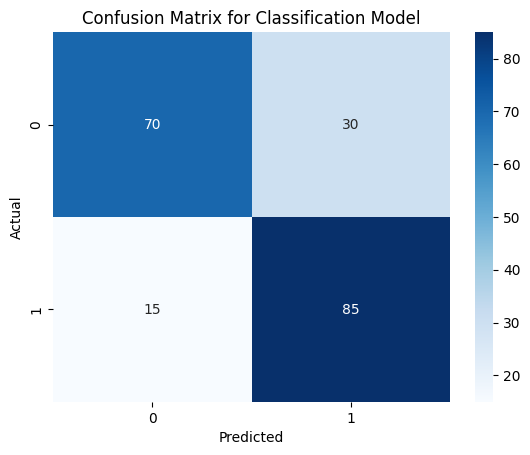

In [157]:
conf_matrix = confusion_matrix(y_test_class, y_pred_class)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Classification Model')
plt.show()


Distribución de los clusters de DBSCAN:


Curva ROC (Receiver Operating Characteristic): Esta es una gráfica de la tasa de verdaderos positivos frente a la tasa de falsos positivos. Un modelo perfecto tendrá un área bajo la curva (AUC) de 1, mientras que un modelo aleatorio tendrá un AUC de 0.5.

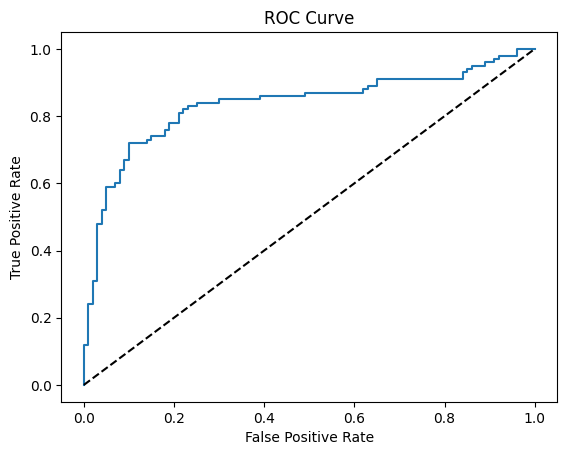

AUC: 0.8344


In [158]:
# Calcular probabilidades de la clase positiva
y_pred_prob = classifier.predict_proba(X_test_class)[:,1]

# Calcular ROC curve
fpr, tpr, thresholds = roc_curve(y_test_class, y_pred_prob)

# Dibujar ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--') # línea aleatoria
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calcular AUC
auc = roc_auc_score(y_test_class, y_pred_prob)
print(f"AUC: {auc}")


Histograma de las probabilidades predichas: Esto te permitirá ver la distribución de las probabilidades que el modelo está prediciendo para cada clase.

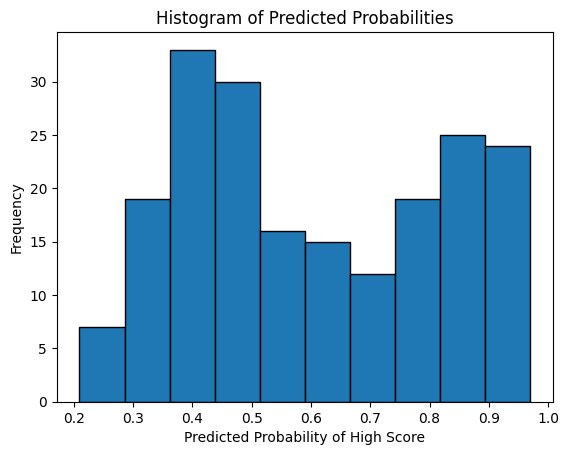

In [159]:
plt.hist(y_pred_prob, bins=10, edgecolor='k')
plt.xlabel('Predicted Probability of High Score')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.show()


Distribución de los clusters cuando se utilizan 3 clusters para KMeans:

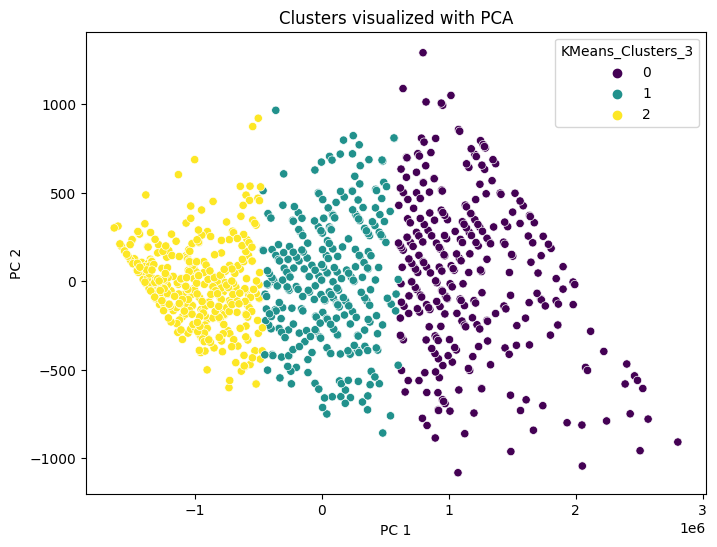

In [160]:
# Aplicamos PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

# Creamos el DataFrame de PCA
pca_df = pd.DataFrame(data = principalComponents, columns = ['PC 1', 'PC 2'])
pca_df['KMeans_Clusters_3'] = kmeans_clusters_3

# Visualizamos los clusters 2D
plt.figure(figsize=(8,6))
sns.scatterplot(x='PC 1', y='PC 2', hue='KMeans_Clusters_3', data=pca_df, palette='viridis')
plt.title('Clusters visualized with PCA')
plt.show()
